##### Copyright 2019 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DeepDream

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/deepdream"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial contains a minimal implementation of DeepDream, as described in this [blog post](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) by Alexander Mordvintsev.

DeepDream is an experiment that visualizes the patterns learned by a neural network. Similar to when a child watches clouds and tries to interpret random shapes, DeepDream over-interprets and enhances the patterns it sees in an image.

It does so by forwarding an image through the network, then calculating the gradient of the image with respect to the activations of a particular layer. The image is then modified to increase these activations, enhancing the patterns seen by the network, and resulting in a dream-like image. This process was dubbed "Inceptionism" (a reference to [InceptionNet](https://arxiv.org/pdf/1409.4842.pdf), and the [movie](https://en.wikipedia.org/wiki/Inception) Inception).

Let's demonstrate how you can make a neural network "dream" and enhance the surreal patterns it sees in an image.

![Dogception](https://www.tensorflow.org/tutorials/generative/images/dogception.png)

In [4]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model

## Choose an image to dream-ify

For this tutorial, let's use an image of a [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg).

In [5]:
from PIL import Image

#original_img = Image.open(r"photo.jpg")
#show(original_img)

90112/83281 [================================] - 0s 0us/step


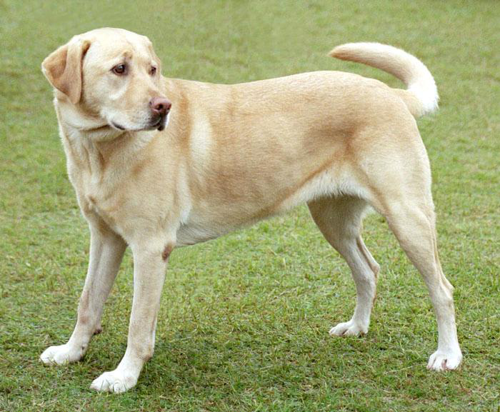

In [6]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):  #conver [-1,1] to [0,255]
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

## Prepare the feature extraction model

Download and prepare a pre-trained image classification model. You will use [InceptionV3](https://keras.io/applications/#inceptionv3) which is similar to the model originally used in DeepDream. Note that any [pre-trained model](https://keras.io/applications/#models-for-image-classification-with-weights-trained-on-imagenet) will work, although you will have to adjust the layer names below if you change this.

In [7]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 0s 0us/step


In [8]:
#IncepV3_model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
#dot_img_file = '/InceptionV3.png'
#tf.keras.utils.plot_model(IncepV3_model, to_file=dot_img_file, show_shapes=True)
#img = PIL.Image.open(dot_img_file)
#display.display(PIL.Image.fromarray(np.array(img)))

The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers. The complexity of the features incorporated depends on layers chosen by you, i.e, lower layers produce strokes or simple patterns, while deeper layers give sophisticated features in images, or even whole objects.

The InceptionV3 architecture is quite large (for a graph of the model architecture see TensorFlow's [research repo](https://github.com/tensorflow/models/tree/master/research/inception)). For DeepDream, the layers of  interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Using different layers will result in different dream-like images. Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures). Feel free to experiment with the layers selected below, but keep in mind that deeper layers (those with a higher index) will take longer to train on since the gradient computation is deeper.

In [9]:
#dot_img_file = '/model_base.png'
#tf.keras.utils.plot_model(base_model, to_file=dot_img_file, show_shapes=True)
#img = PIL.Image.open(dot_img_file)
#display.display(PIL.Image.fromarray(np.array(img)))

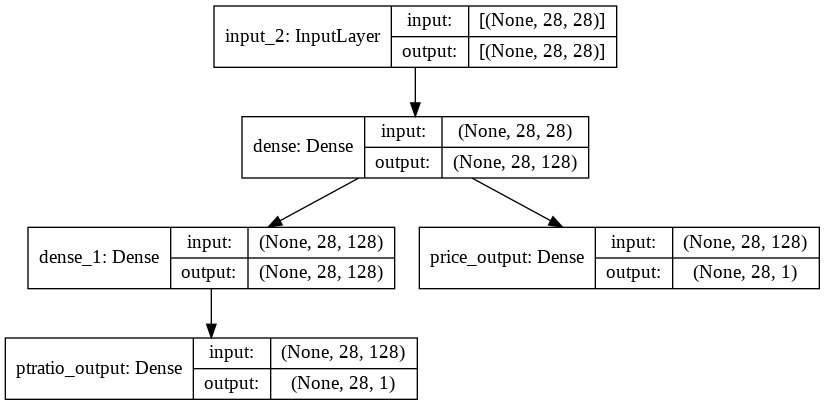

In [10]:
from tensorflow import keras
def build_model():
    # Define model layers.
    input_layer = keras.layers.Input(shape=[28,28])
    first_dense = keras.layers.Dense(units='128', activation='relu')(input_layer)
    # Y1 output will be fed from the first dense
    y1_output = keras.layers.Dense(units='1', name='price_output')(first_dense)
    second_dense = keras.layers.Dense(units='128',activation='relu')(first_dense)
    # Y2 output will be fed from the second dense
    y2_output = keras.layers.Dense(units='1',name='ptratio_output')(second_dense)
    # Define the model with the input layer 
    # and a list of output layers
    model = keras.Model(inputs=input_layer,outputs=[y1_output, y2_output])
    return model

model_test = build_model()

tf.keras.utils.plot_model(model_test, show_shapes=True)


In [11]:
# Maximize the activations of these layers
names = ['mixed6']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [12]:
#from PIL import Image

#dot_img_file = '/model_only_mix3.png'
#tf.keras.utils.plot_model(dream_model, to_file=dot_img_file, show_shapes=True)
#img = PIL.Image.open(dot_img_file)
#display.display(PIL.Image.fromarray(np.array(img)))

## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [13]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

## Gradient ascent

Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image. 

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

The method that does this, below, is wrapped in a `tf.function` for performance. It uses an `input_signature` to ensure that the function is not retraced for different image sizes or `steps`/`step_size` values. See the [Concrete functions guide](../../guide/concrete_function.ipynb) for details.

In [36]:
# calculate loss from a specific layer
def calc_loss(img, model,channel = 0):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0) #增加demention, 因为只输入了一个图片所以是3维，but the model requires 4-d

  layer_activations = model(img_batch) # check ouput

  #tf.print("layer_activations: ",layer_activations.shape)
  
  if len(layer_activations) == 1:   #'outputs' only contains one mix layer? covert to a list
    layer_activations = [layer_activations]

  tol_losses = []
  for act in layer_activations:

    #tf.print("act: ",act.shape)
    channel = act[0, :, :, channel]   #  channel number

    layer_loss = tf.math.reduce_mean(act)  # the whole layer activation
    channel_loss = tf.math.reduce_mean(channel)  # the specific channel activation

    tol_losses.append(channel_loss) 
  return  tf.reduce_sum(tol_losses)



class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32), #image size is unknown
        tf.TensorSpec(shape=[], dtype=tf.int32),    # steps
        tf.TensorSpec(shape=[], dtype=tf.float32),)  # step_size
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")

      loss = tf.constant(0.0)

      scale_L1 = tf.constant(-1e-4)
      scale_L2 = tf.constant(-1e-4)
      scale_tv = tf.constant(-1e-4)
      
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          activation = calc_loss(img, self.model,channel=0)  #______________________________________________ tf.negative

          tf.print("activation: ",activation)

          L1 = tf.reduce_sum(tf.abs(img))
          tf.print("L1: ",L1)

          L2 = tf.reduce_sum(img ** 2)
          tf.print("L2: ",L2)

          tv = tf.image.total_variation(img) # total variance loss

          scale_L1 = tf.cast(scale_L1, L1.dtype)
          scale_L2 = tf.cast(scale_L2, L2.dtype)
          scale_tv = tf.cast(scale_tv, tv.dtype)

          reg_L1 = tf.scalar_mul(scale_L1,L1)
          reg_L2 = tf.scalar_mul(scale_L2,L2)
          reg_tv = tf.scalar_mul(scale_tv,tv) #+ tf.reduce_sum(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES))#basic L2 loss

          loss = tf.negative(activation + reg_tv + reg_L1 + reg_L2)   #4-D Tensor of shape [batch, height, width, channels] or 3-D Tensor of shape [height, width, channels].
          #tf.print("total_regularization: ",total_reg)
          

    
        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

    #    opt.apply_gradients(zip([gradients], [img]))
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img - gradients*step_size
        # returns a tensor of the same type and shape as t with its values clipped to clip_value_min and clip_value_max
        img = tf.clip_by_value(img, -1, 1)  

      return loss, img

In [37]:
deepdream = DeepDream(dream_model)

## Main Loop

In [38]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img) #The inputs pixel values are scaled between -1 and 1, sample-wise
  img = tf.convert_to_tensor(img)


  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:  # run 100 steps each time
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))  #img [height,width,channel]
    
    #display.clear_output(wait=True) # wait --> Wait to clear the output until new output is available to replace it.
    show(deprocess(img))  # img 没变，因为没赋值
    print ("Step {}, loss {}".format(step, loss))

  #show the final result
  result = deprocess(img)
  #display.clear_output(wait=True)
  show(result)

  return result

<class 'numpy.ndarray'>


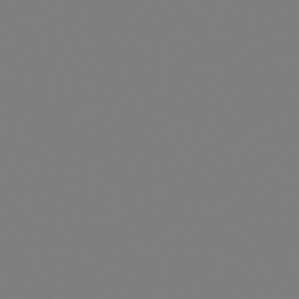


activation:  0.677677035
L1:  2405.99365
L2:  32.3919716
activation:  0.454883128
L1:  4437.74707
L2:  135.350693
activation:  0.939335465
L1:  5692.21973
L2:  220.720963
activation:  1.34625018
L1:  6595.13184
L2:  294.059448
activation:  1.73786151
L1:  7308.64697
L2:  360.176666
activation:  2.15649247
L1:  7911.13135
L2:  421.646606
activation:  2.33731055
L1:  8430.54199
L2:  480.544769
activation:  2.75785804
L1:  8913.1709
L2:  537.43927
activation:  2.9999876
L1:  9301.58789
L2:  588.832275
activation:  3.24467063
L1:  9697.42578
L2:  639.965393
activation:  3.54066658
L1:  9995.06055
L2:  684.254211
activation:  3.73808813
L1:  10310.2334
L2:  728.518677
activation:  3.90451241
L1:  10589.8115
L2:  770.289673
activation:  4.18770361
L1:  10855.9873
L2:  811.179
activation:  4.42041206
L1:  11084.2402
L2:  850.740906
activation:  4.54861736
L1:  11301.3271
L2:  885.603149
activation:  4.73859644
L1:  11505.9229
L2:  921.748
activation:  4.85160637
L1:  11721.8955
L2:  954.731


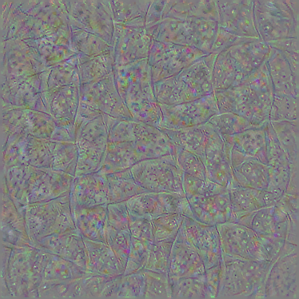

Step 100, loss -4.977851867675781
activation:  9.53545
L1:  17352.3164
L2:  2390.71265
activation:  9.61169338
L1:  17378.6504
L2:  2395.63599
activation:  9.57211113
L1:  17391.2988
L2:  2405.76
activation:  9.59966373
L1:  17402.1191
L2:  2411.86108
activation:  9.76924515
L1:  17419.1543
L2:  2422.552
activation:  9.63573933
L1:  17410.1758
L2:  2420.91748
activation:  9.63726616
L1:  17464.4375
L2:  2436.30469
activation:  9.67433
L1:  17490.1406
L2:  2443.40601
activation:  9.65046406
L1:  17515.0625
L2:  2455.18188
activation:  9.8247242
L1:  17509.6895
L2:  2461.36548
activation:  9.63713741
L1:  17531.5039
L2:  2473.00708
activation:  9.8443346
L1:  17538.9141
L2:  2479.78857
activation:  9.79336452
L1:  17586.8496
L2:  2487.33496
activation:  9.82485199
L1:  17600.8594
L2:  2493.15894
activation:  9.78535938
L1:  17612.2285
L2:  2502.12036
activation:  9.86201096
L1:  17622.7891
L2:  2508.2
activation:  9.78303909
L1:  17646.4941
L2:  2514.32764
activation:  9.85684299
L1:  17

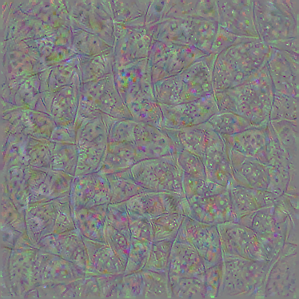

Step 200, loss -5.71842098236084
activation:  10.7199211
L1:  18439.3164
L2:  2914.79443
activation:  10.6099339
L1:  18442.7305
L2:  2913.87549
activation:  10.7970667
L1:  18466.0723
L2:  2922.32153
activation:  10.6327515
L1:  18458.6426
L2:  2918.73755
activation:  10.7051535
L1:  18464.4375
L2:  2924.58911
activation:  10.6608706
L1:  18485.5938
L2:  2927.03
activation:  10.6902304
L1:  18484.8906
L2:  2932.94263
activation:  10.7132654
L1:  18486.5742
L2:  2933.58276
activation:  10.7892656
L1:  18476.918
L2:  2937.20801
activation:  10.73386
L1:  18484.5801
L2:  2937.92041
activation:  10.7974291
L1:  18460.291
L2:  2939.27173
activation:  10.7660522
L1:  18469.082
L2:  2937.7146
activation:  10.7724495
L1:  18469.498
L2:  2943.60425
activation:  10.7273426
L1:  18469.459
L2:  2942.33
activation:  10.8092966
L1:  18475.9531
L2:  2950.48364
activation:  10.7622833
L1:  18503.2422
L2:  2948.28027
activation:  10.7896805
L1:  18519.7012
L2:  2959.81201
activation:  10.7006378
L1:  

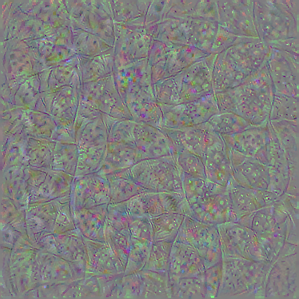

Step 300, loss -6.0640716552734375
activation:  11.1764059
L1:  19107.6309
L2:  3225.55591
activation:  11.2021961
L1:  19096.1074
L2:  3221.22119
activation:  11.1635199
L1:  19073.2012
L2:  3221.1853
activation:  11.2947702
L1:  19070.1289
L2:  3222.89941
activation:  11.0611486
L1:  19075.9922
L2:  3223.36768
activation:  11.2439537
L1:  19093.1191
L2:  3229.88452
activation:  11.0545931
L1:  19111.0742
L2:  3231.8623
activation:  11.2094917
L1:  19114.3438
L2:  3234.7439
activation:  11.1144934
L1:  19130.4238
L2:  3239.40332
activation:  11.1766949
L1:  19118.625
L2:  3241.42822
activation:  11.1296358
L1:  19139.8613
L2:  3247.88647
activation:  11.2208862
L1:  19162.6504
L2:  3254.83862
activation:  11.1524563
L1:  19154.4492
L2:  3256.76514
activation:  11.2166977
L1:  19151.834
L2:  3256.01074
activation:  11.300643
L1:  19167.7207
L2:  3259.21802
activation:  11.1584349
L1:  19164.7656
L2:  3258.01196
activation:  11.2708368
L1:  19179.9277
L2:  3264.82959
activation:  11.336

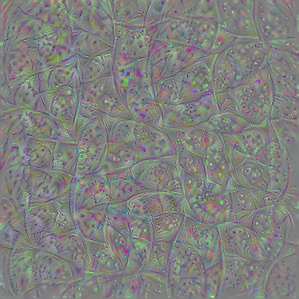

Step 400, loss -6.355974197387695
activation:  11.6569738
L1:  19506.8848
L2:  3428.04468
activation:  11.5883436
L1:  19490.2441
L2:  3421.44409
activation:  11.5858154
L1:  19511.1621
L2:  3428.8667
activation:  11.545846
L1:  19509.625
L2:  3426.23926
activation:  11.6757193
L1:  19521.9785
L2:  3432.92554
activation:  11.5370369
L1:  19518.2031
L2:  3428.31128
activation:  11.6055756
L1:  19532.5605
L2:  3435.45361
activation:  11.5072107
L1:  19512.5762
L2:  3433.38965
activation:  11.6582766
L1:  19517.7441
L2:  3436.021
activation:  11.4661789
L1:  19539.3535
L2:  3441.17847
activation:  11.603302
L1:  19544.3027
L2:  3445.34546
activation:  11.458106
L1:  19570.6465
L2:  3450.19434
activation:  11.6311359
L1:  19576.5645
L2:  3451.43457
activation:  11.516283
L1:  19597.1504
L2:  3460.33643
activation:  11.5899162
L1:  19592.6602
L2:  3459.41357
activation:  11.495676
L1:  19590.1
L2:  3460.88135
activation:  11.5812168
L1:  19591.0059
L2:  3464.36426
activation:  11.5390472
L1

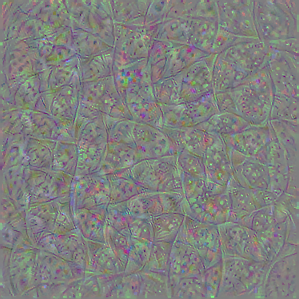

Step 500, loss -6.535721778869629
activation:  11.7382326
L1:  19763.7598
L2:  3562.23267
activation:  11.8162174
L1:  19780.709
L2:  3569.67871
activation:  11.8053322
L1:  19788.5781
L2:  3567.82788
activation:  11.8296604
L1:  19764.1211
L2:  3572.53906
activation:  11.8322639
L1:  19757.1016
L2:  3566.38306
activation:  11.87778
L1:  19749.498
L2:  3570.62695
activation:  11.8275404
L1:  19774.2812
L2:  3567.67236
activation:  11.850091
L1:  19773.8965
L2:  3573.54468
activation:  11.8780165
L1:  19779.9336
L2:  3572.33643
activation:  11.8556576
L1:  19779.8223
L2:  3573.6792
activation:  11.8128262
L1:  19773.2324
L2:  3572.31519
activation:  11.8567886
L1:  19762.3926
L2:  3574.39819
activation:  11.7896223
L1:  19770.0605
L2:  3569.73218
activation:  11.8286591
L1:  19771.8125
L2:  3576.54761
activation:  11.8633709
L1:  19765.248
L2:  3575.62915
activation:  11.7259541
L1:  19764.166
L2:  3579.479
activation:  11.9474745
L1:  19784.6973
L2:  3582.19482
activation:  11.7923241


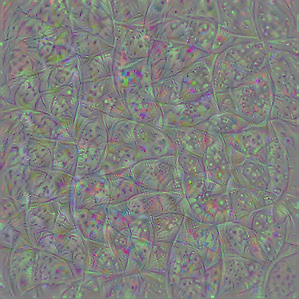

Step 600, loss -6.58424186706543
activation:  12.0193462
L1:  19970.1582
L2:  3672.19238
activation:  12.0325108
L1:  19953.1016
L2:  3671.83472
activation:  11.9901047
L1:  19963.0391
L2:  3670.59106
activation:  11.9215479
L1:  19965.5742
L2:  3677.99292
activation:  12.0241547
L1:  19967.3281
L2:  3674.70703
activation:  11.8853168
L1:  19958.5645
L2:  3676.44141
activation:  12.0043612
L1:  19968.5078
L2:  3679.3479
activation:  11.8348103
L1:  19982.8027
L2:  3682.17407
activation:  11.994441
L1:  19996.0156
L2:  3685.40845
activation:  11.8294277
L1:  20000.7461
L2:  3687.65552
activation:  11.981967
L1:  20022.2402
L2:  3694.90454
activation:  11.8441257
L1:  20047.6309
L2:  3698.51245
activation:  12.0213318
L1:  20045.918
L2:  3704.46924
activation:  11.8979683
L1:  20033.6895
L2:  3699.77808
activation:  12.054738
L1:  20062.082
L2:  3705.07593
activation:  11.9424696
L1:  20070.1582
L2:  3705.97729
activation:  12.0745335
L1:  20055.0488
L2:  3705.42407
activation:  11.96836

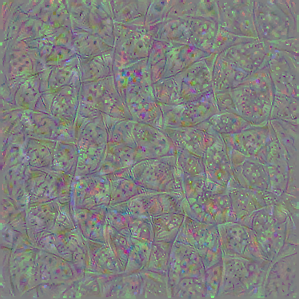

Step 700, loss -6.650160789489746
activation:  12.2105532
L1:  20175.8184
L2:  3777.47339
activation:  12.1240196
L1:  20162.2188
L2:  3776.08301
activation:  12.1588421
L1:  20181.9277
L2:  3777.28638
activation:  12.2134857
L1:  20169.2422
L2:  3777.37061
activation:  12.1887188
L1:  20149.5625
L2:  3774.73096
activation:  12.0912704
L1:  20156.4883
L2:  3774.27954
activation:  12.1957
L1:  20156.5801
L2:  3773.65674
activation:  12.2626381
L1:  20152.4297
L2:  3773.11914
activation:  12.1650066
L1:  20131.7461
L2:  3766.84131
activation:  12.1671362
L1:  20139.0684
L2:  3769.17114
activation:  12.2108898
L1:  20123.8145
L2:  3765.78296
activation:  12.05795
L1:  20123.3496
L2:  3768.33936
activation:  12.2224255
L1:  20129.8418
L2:  3769.80176
activation:  12.0560722
L1:  20156.498
L2:  3773.69531
activation:  12.2128344
L1:  20147.9512
L2:  3777.35327
activation:  12.0563812
L1:  20180.8086
L2:  3778.92773
activation:  12.1270037
L1:  20176.9473
L2:  3780.87476
activation:  12.0778

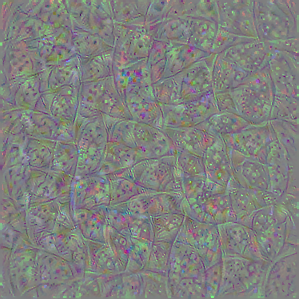

Step 800, loss -6.804770469665527
activation:  12.2928886
L1:  20254.9199
L2:  3833.96387
activation:  12.2514343
L1:  20249.498
L2:  3836.88916
activation:  12.2330294
L1:  20251.2148
L2:  3839.37573
activation:  12.2707787
L1:  20263.1641
L2:  3843.75732
activation:  12.2179031
L1:  20260.8555
L2:  3841.92529
activation:  12.3094139
L1:  20268.1758
L2:  3847.68677
activation:  12.288559
L1:  20259.6953
L2:  3847.22339
activation:  12.2592897
L1:  20291.3965
L2:  3851.38184
activation:  12.373107
L1:  20278.5566
L2:  3847.5647
activation:  12.2055807
L1:  20286.1914
L2:  3849.32056
activation:  12.3767824
L1:  20270.4336
L2:  3847.29
activation:  12.1584778
L1:  20270.9043
L2:  3849.50781
activation:  12.3213148
L1:  20270.9961
L2:  3851.77881
activation:  12.2054405
L1:  20276.9648
L2:  3851.51147
activation:  12.254282
L1:  20280.6426
L2:  3851.30396
activation:  12.1646891
L1:  20306.709
L2:  3856.06177
activation:  12.3397083
L1:  20295.5645
L2:  3856.18042
activation:  12.2263441

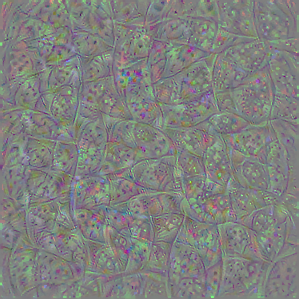

Step 900, loss -6.730470657348633
activation:  12.384038
L1:  20408.7012
L2:  3918.85669
activation:  12.3086061
L1:  20429.2715
L2:  3921.90332
activation:  12.4145727
L1:  20422.2969
L2:  3919.53564
activation:  12.2921362
L1:  20424.1113
L2:  3920.72095
activation:  12.5136929
L1:  20411.9141
L2:  3919.39111
activation:  12.2728624
L1:  20388.4863
L2:  3916.73486
activation:  12.4009867
L1:  20404.3066
L2:  3920.51172
activation:  12.3381901
L1:  20409.6836
L2:  3922.08887
activation:  12.4308739
L1:  20380.7949
L2:  3917.11157
activation:  12.3410597
L1:  20383.9746
L2:  3917.57471
activation:  12.4376936
L1:  20382.5312
L2:  3914.10278
activation:  12.4047365
L1:  20386.2051
L2:  3912.61377
activation:  12.3741579
L1:  20379.8398
L2:  3912.96851
activation:  12.4516878
L1:  20399.0312
L2:  3914.85229
activation:  12.3978567
L1:  20403.1543
L2:  3913.71411
activation:  12.4129791
L1:  20410.9727
L2:  3912.99854
activation:  12.3770809
L1:  20393.834
L2:  3913.02637
activation:  12.

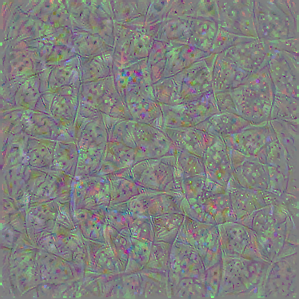

Step 1000, loss -6.999783515930176


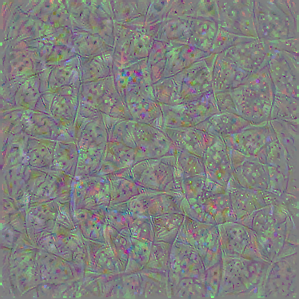

In [40]:
print(type(original_img))
#print(original_img.shape)  # original_img (RGB) [0-255]



noise = tf.random.normal(shape=[299,299,3],stddev = 0.01,dtype=tf.dtypes.float32)  #tensor
#print(tf.image.per_image_standardization(noise))
noise = deprocess(noise)
noise = noise.numpy()
show(noise)
print()

dream_img = run_deep_dream_simple(img=noise, 
                                  steps=500, step_size=0.02)

## Taking it up an octave

Pretty good, but there are a few issues with this first attempt: 

  1. The output is noisy (this could be addressed with a `tf.image.total_variation` loss).
  1. The image is low resolution.
  1. The patterns appear like they're all happening at the same granularity.
  
One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this you can perform the previous gradient ascent approach, then increase the size of the image (which is referred to as an octave), and repeat this process for multiple octaves.


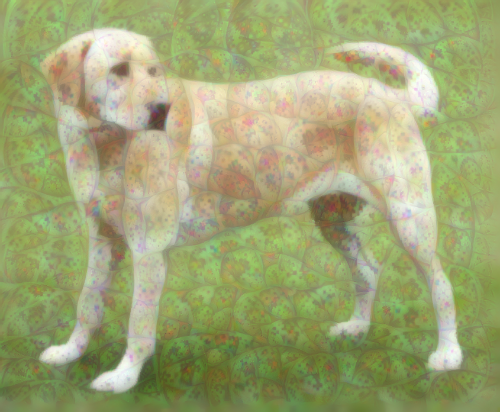

17.814433336257935

In [18]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = original_img
#img = tf.constant(np.array(noise))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

## Optional: Scaling up with tiles

One thing to consider is that as the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves.

To avoid this issue you can split the image into tiles and compute the gradient for each tile.

Applying random shifts to the image before each tiled computation prevents tile seams from appearing.

Start by implementing the random shift:

In [19]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

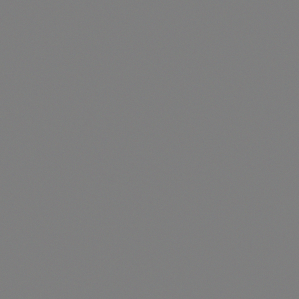

In [20]:
shift, img_rolled = random_roll(np.array(noise), 512) #
show(img_rolled)

Here is a tiled equivalent of the `deepdream` function defined earlier:

In [21]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):                      #512
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [22]:
get_tiled_gradients = TiledGradients(dream_model)

Putting this together gives a scalable, octave-aware deepdream implementation:

In [23]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):  #1.3
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

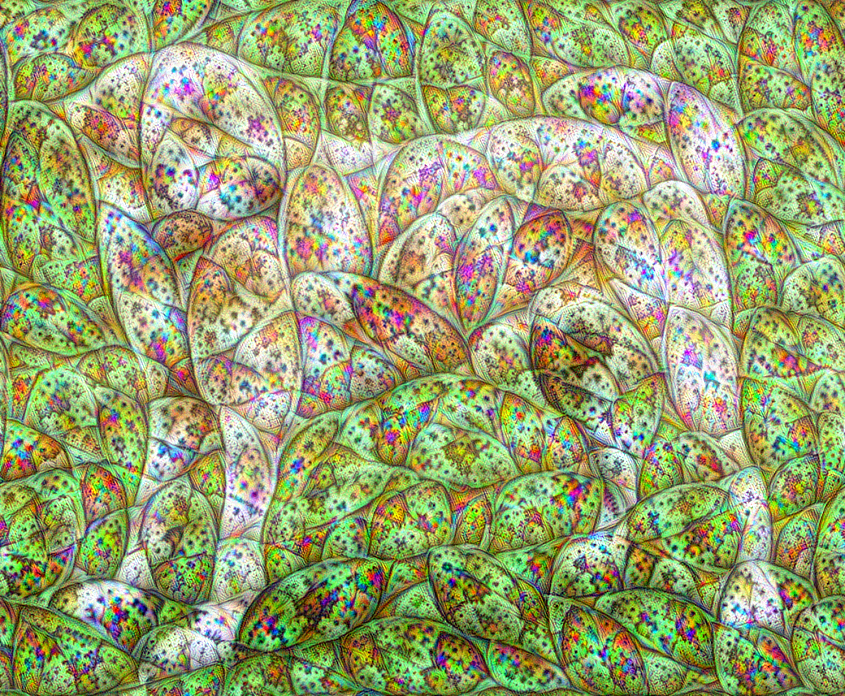

Octave 2, Step 90


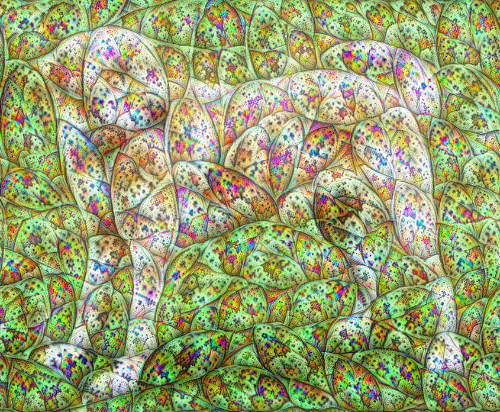

In [24]:
img = run_deep_dream_with_octaves(img=original_img, steps_per_octave=100,step_size=0.02)

#display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

Much better! Play around with the number of octaves, octave scale, and activated layers to change how your DeepDream-ed image looks.

Readers might also be interested in [TensorFlow Lucid](https://github.com/tensorflow/lucid) which expands on ideas introduced in this tutorial to visualize and interpret neural networks.